# KAGGLE: Natural Language Processing with Diaster Tweets
AUTHOR: SungwookLE  
DATE: '21.7/9  
REFERENCE: https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm

### Competition Description
<img src="https://storage.googleapis.com/kaggle-media/competitions/nlp1-cover.jpg" width=1000, height=150>  

 It’s not always clear whether a person’s words are actually announcing a disaster. [This tweet](https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png) explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.  
 In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a [quick tutorial](https://www.kaggle.com/philculliton/nlp-getting-started-tutorial) to get you up and running. Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.  
 Another [reference](https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained#7.-LSTM) is here.  

### DATA
#### 1) What am I predicting
- Predict whether a given tweet is about a real diaster or not. If so, predict a `1`, If not, predict a `0`.  

#### 2) Columns
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output

In [2]:
print(check_output(['ls','input']).decode('utf8'))

nlp-getting-started.zip
sample_submission.csv
test.csv
train.csv



In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## START
## 1. EDA(Exploratory Data Analysis, 탐색적 데이터 분석)

In [5]:
tweet = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

Text(0, 0.5, 'tweets')

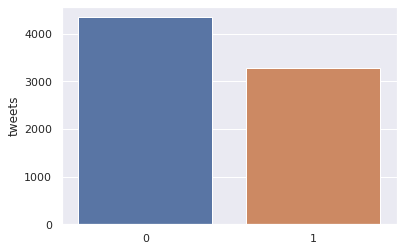

In [6]:
# Checking the class distribution
x = tweet['target'].value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('tweets')

Text(0.5, 0.98, 'Characters in tweets')

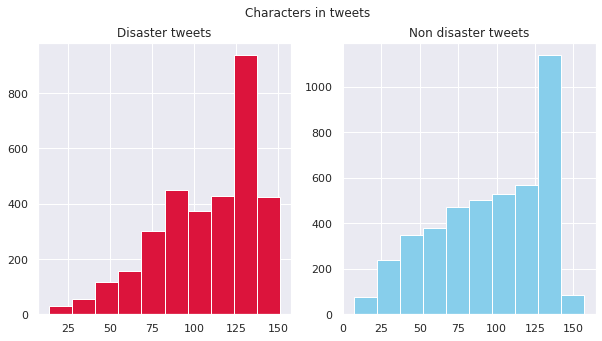

In [7]:
# Number of characters in tweets
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet.loc[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='crimson')
ax1.set_title('Disaster tweets')

tweet_len = tweet.loc[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='skyblue')
ax2.set_title('Non disaster tweets')
fig.suptitle('Characters in tweets')

Text(0.5, 0.98, 'Words in a tweet')

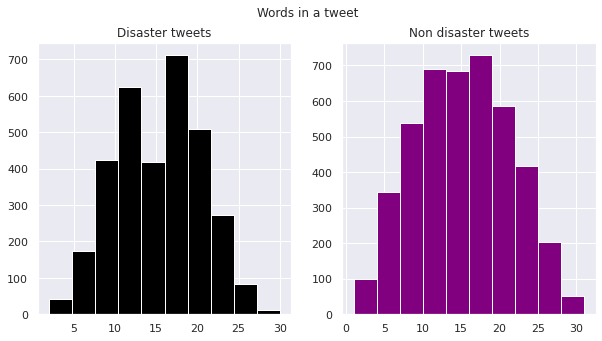

In [13]:
# Number of words in a tweets
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet.loc[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, color = 'black')
ax1.set_title('Disaster tweets')

tweet_len = tweet.loc[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color = 'purple')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

Text(0.5, 0.98, 'Average word length in each tweet')

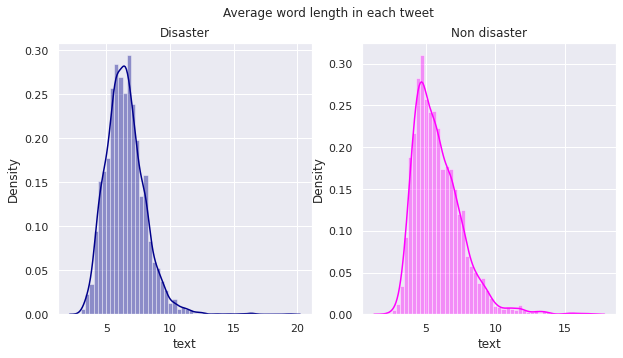

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
word = tweet.loc[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.distplot(word, ax=ax1, color='darkblue')
ax1.set_title('Disaster')

word = tweet.loc[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
sns.distplot(word, ax=ax2, color='magenta')
ax2.set_title('Non disaster')
fig.suptitle('Average word length in each tweet')

In [20]:
def create_corpus(target):
    corpus=[]
    for x in tweet.loc[tweet['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [21]:
def create_corpus_df(tweet, target):
    corpus =[]
    for x in tweet.loc[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 20 artists>

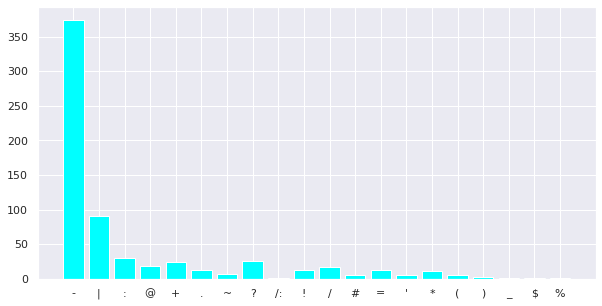

In [36]:
from collections import defaultdict
# Punctuations in non-disaster class
plt.figure(figsize=(10,5))
corpus = create_corpus(0)
dic = defaultdict(int)

import string
special = string.punctuation

for i in corpus:
    if i in special:
        dic[i] +=1

x,y = zip(*dic.items())
plt.bar(x, y, color ='cyan')


<BarContainer object of 18 artists>

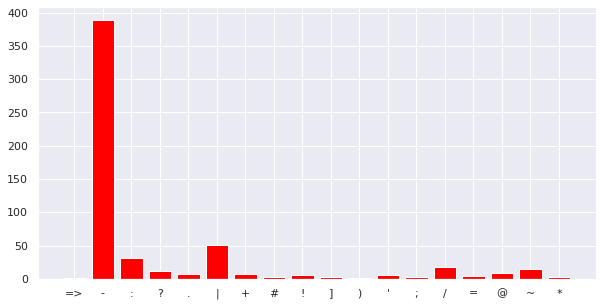

In [37]:
# Punctuations in disaster class
plt.figure(figsize=(10,5))
corpus = create_corpus(1)
dic = defaultdict(int)

for i in (corpus):
    if i in special:
        dic[i]+=1
x,y = zip(*dic.items())
plt.bar(x, y, color='red')

<AxesSubplot:>

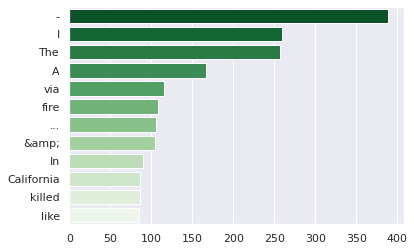

In [43]:
# Common words
from collections import Counter
import nltk
#nltk.download('stopwords')
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

corpus = create_corpus(1)
counter = Counter(corpus)
most = counter.most_common()
x=[]
y=[]

for word, count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x, palette='Greens_r')

<AxesSubplot:>

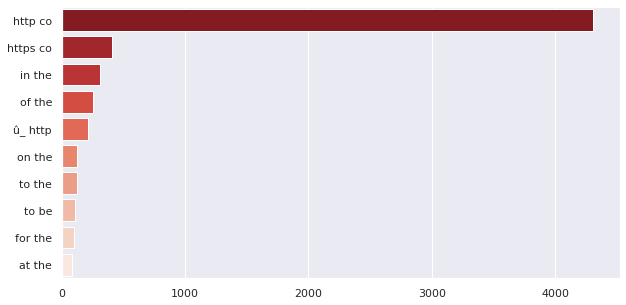

In [46]:
# Bigram analysis
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]

x,y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x, palette='Reds_r')


In [80]:
df = pd.concat([tweet, test])
df.shape

(10876, 5)

USA          494
UK           124
Africa        72
India         28
Worldwide     28
Canada        16
Name: location, dtype: int64


<AxesSubplot:xlabel='location'>

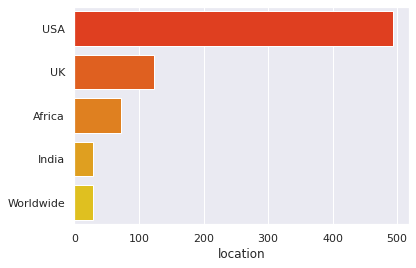

In [81]:
# Renaming locations means

df['location']=df['location'].map({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"})

print(df['location'].value_counts())

sns.barplot(y = df['location'].value_counts()[:5].index, x = df['location'].value_counts()[:5],
            palette='autumn')

In [85]:
import re
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning fuction to both test and traing datasets
df['text']= df['text'].apply(lambda x: clean_text(x))
# Let's take a look at the updated text
df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [86]:
#Removing Emojis

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
    
df['text']=df['text'].apply(lambda x: remove_emoji(x))

## 2. Model
We are going to use LSTM (long short-term memory) model because it solves a vanishing gradient problem

In [89]:
tweet_1 = tweet['text'].values
test_1 = test['text'].values
sentiments = tweet['target'].values

We need to perform **tokenization** - the processing of segmenting text into sentences of words. In the process we throw away punctuation and extra symbols too. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

In [91]:
from keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer()

In [92]:
word_tokenizer.fit_on_texts(tweet_1)
vocab_length = len(word_tokenizer.word_index) + 1

In [93]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

In [94]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [100]:
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
nltk.download('punkt')

longest_train = max(tweet_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

padded_sentences = pad_sequences(embed(tweet_1), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(test_1),
    length_long_sentence,
    padding='post'
)

[nltk_data] Downloading package punkt to /home/joker1251/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


To obtain a vector representation for words we can use an unsuperviesed learning algorithm called **GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together

In [113]:
embeddings_dictionary = dict()
embeddings_dim = 100
glove_file = open('input/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [115]:
embedding_matrix = np.zeros((vocab_length, embeddings_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences,
    sentiments,
    test_size=0.25)

In [ ]:
def BLSTM():
    model = Sequential()
    

## 마저하기, 재밋네 , NLP